# LAB 4

# Uncertainty Quantification (UQ)

# The short guide into the UQ workflow. 

## Site specific case

The uncertainty quatification complements the the Sensitivity Analysis  frmework. Currently, it runs only for one output (i.e. we cannot study more than one output in this example).  

Author: Elchin Jafarov & Ruth Rutter

Date: 02/27/2022

In [1]:
import os
os.chdir('/work')
!pwd

/work


### 1. UQ Instantiation

In [2]:
import uncertainpy as un
import chaospy as cp                       # To create distributions
import numpy as np                         # For the time array
from scipy.integrate import odeint         # To integrate our equation
import matplotlib.pyplot as plt
import math
import json
import subprocess
import sys
import netCDF4 as nc
import output_utils as ou
%matplotlib inline

### 2. UQ setup

Let's set study parameters and an output 

In [3]:
#PARAMS = {'cmax': [250,400], 'cfall(0)': [0.02,0.2]}
PARAMS = {'cmax': [300,350]}

VAR = 'GPP'
PFTNUM = 1
CMTNUM = 4
PXx = 0; PXy = 0
H_RUNFOLDER = '.'

In [4]:
!scripts/outspec_utils.py config/output_spec.csv --on GPP m p

                Name                Units       Yearly      Monthly        Daily          PFT Compartments       Layers    Data Type     Description
                 GPP            g/m2/time            y            m      invalid            p                   invalid       double     GPP


`adjust_param` and `collect_outputs` are two utilitary functions that we need to run the model (see `run_dvmdostem`). `adjust_param` update in the cmt_calparbgc.txt with new parameter values. `collect_outputs` get an output array from the netcdf file and passes it back to the `run_dvmdostem`

In [5]:
def adjust_param(param_name, param_value):
    data = !scripts/param_util.py --dump-block-to-json {H_RUNFOLDER}/default_parameters/cmt_calparbgc.txt {CMTNUM}
    
    jdata = json.loads(data[0])

    pft = 'pft{}'.format(PFTNUM)
    jdata[pft][param_name] = param_value

    with open("tmp_json.json", 'w') as f:
        json.dump(jdata, f)

    new_data = !scripts/param_util.py --fmt-block-from-json tmp_json.json {H_RUNFOLDER}/default_parameters/cmt_calparbgc.txt

    with open('{:}/parameters/cmt_calparbgc.txt'.format(H_RUNFOLDER), 'w') as f:
        # make sure to add newlines!
        f.write('\n'.join(new_data))

In [6]:
def collect_outputs():
    # Get the model output
    ds = nc.Dataset('{}/output/{}_monthly_eq.nc'.format(H_RUNFOLDER,VAR))
    print(ds)
    var_data = ds.variables[VAR][:]
    print(var_data.shape)

    #yr_gpp = ou.sum_monthly_flux_to_yearly(gpp)
    #output_data = yr_gpp[-1:,PFTNUM,PXy,PXx]
    
    #Veg var by PFT
    output_data = var_data[-60:,PFTNUM,PXy,PXx]

    #Soil var, single
    #output_data = var_data[-60:,PXy,PXx]
    
    print(output_data.shape)
    print(output_data)
    
    # Get the parameter value for the run
    #paramdata = !scripts/param_util.py --dump-block-to-json {H_RUNFOLDER}/parameters/cmt_calparbgc.txt {CMTNUM}
    #jparamdata = json.loads(paramdata[0])
    #pft = 'pft{}'.format(PFTNUM)
    #run_param_value = jparamdata[pft][PARAM]
    
    return output_data

In [7]:
def run_dvmdostem(**params_and_values):
    
    #Find and replace the parameters in the parameter file with the provided value
    for param in params_and_values:
        print("Modifying parameter {}".format(param))
        adjust_param(param, params_and_values[param])

    #Run dvmdostem
    run_result = !./dvmdostem -l fatal -p 10 -e 50 -s 20 -t 0 -n 0 --force-cmt {CMTNUM}

    #Load specified variable output and return. For now, the output needs to be (time,PFT,Y,X)
    var_output = collect_outputs()

    return None, var_output

In [8]:
# Create a model from the calling function and add labels
model = un.Model(run=run_dvmdostem, labels=["Months", VAR])
model.labels

['Months', 'GPP']

In [9]:
# Create the parameter dictionary with distributions
# Arbitray numbers for testing
parameters = {}
for key in PARAMS:
    parameters[key] = cp.Uniform(PARAMS[key][0], PARAMS[key][1])

parameters

{'cmax': Uniform(lower=300, upper=340)}

In [10]:
# Set up the uncertainty quantification
# Temporarily forced to sequential because separate working directories are not implemented
# Set up the uncertainty quantification
UQ = un.UncertaintyQuantification(model=model,
                                  parameters=parameters, CPUs=None)


### 3. UQ Run

In [11]:
# Perform the uncertainty quantification using
# polynomial chaos with point collocation (by default)
# We set the seed to easier be able to reproduce the result
#data = UQ.quantify(seed=10)
data = UQ.quantify()

chaospy.orth_ttr name is to be deprecated; Use chaospy.expansion.stieltjes instead
Running model:   0%|                                                          | 0/12 [00:00<?, ?it/s]

Modifying parameter cmax


Running model:   8%|████▏                                             | 1/12 [00:35<06:30, 35.47s/it]

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Git_SHA: v0.5.4-78-gf19a55-dirty
    dimensions(sizes): time(600), y(10), x(10), pft(10)
    variables(dimensions): float64 GPP(time, pft, y, x), |S1 albers_conical_equal_area()
    groups: 
(600, 10, 10, 10)
(60,)
[0.0 0.0 0.0 0.0 0.0 43.68702292442322 58.09272336959839
 59.416083574295044 6.00697124004364 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 43.689709186553955 58.10419845581055 59.41981530189514 6.00740373134613
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 43.69256949424744 58.11578178405762
 59.4232976436615 6.007810592651367 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 43.695019245147705 58.12524461746216 59.426401138305664 6.008147120475769
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 43.69749450683594 58.13465142250061
 59.42921423912048 6.008458733558655 0.0 0.0 0.0]
Modifying parameter cmax


Running model:  17%|████████▎                                         | 2/12 [01:10<05:52, 35.21s/it]

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Git_SHA: v0.5.4-78-gf19a55-dirty
    dimensions(sizes): time(600), y(10), x(10), pft(10)
    variables(dimensions): float64 GPP(time, pft, y, x), |S1 albers_conical_equal_area()
    groups: 
(600, 10, 10, 10)
(60,)
[0.0 0.0 0.0 0.0 0.0 40.34422469139099 54.11472809314728
 55.022202253341675 5.550820469856262 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 40.34578061103821 54.118367433547974 55.02553057670593 5.55105996131897
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 40.34860348701477 54.12861502170563
 55.02875471115112 5.55141294002533 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 40.351542711257935 54.139132022857666 55.03177237510681
 5.5517518520355225 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 40.35453701019287
 54.149585604667664 55.03458786010742 5.552071213722229 0.0 0.0 0.0]
Modifying parameter cmax


Running model:  25%|████████████▌                                     | 3/12 [01:46<05:21, 35.76s/it]

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Git_SHA: v0.5.4-78-gf19a55-dirty
    dimensions(sizes): time(600), y(10), x(10), pft(10)
    variables(dimensions): float64 GPP(time, pft, y, x), |S1 albers_conical_equal_area()
    groups: 
(600, 10, 10, 10)
(60,)
[0.0 0.0 0.0 0.0 0.0 43.08723568916321 57.16946363449097 58.59297776222229
 5.914871335029602 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 43.0894079208374
 57.178632974624634 58.59541416168213 5.915142059326172 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 43.09161710739136 57.18784809112549 58.59763717651367
 5.9153958559036255 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 43.09385800361633
 57.19710445404053 58.599698543548584 5.915635824203491 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 43.010634899139404 57.20910668373108 58.57613921165466
 5.915473222732544 0.0 0.0 0.0]
Modifying parameter cmax


Running model:  33%|████████████████▋                                 | 4/12 [02:22<04:44, 35.61s/it]

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Git_SHA: v0.5.4-78-gf19a55-dirty
    dimensions(sizes): time(600), y(10), x(10), pft(10)
    variables(dimensions): float64 GPP(time, pft, y, x), |S1 albers_conical_equal_area()
    groups: 
(600, 10, 10, 10)
(60,)
[0.0 0.0 0.0 0.0 0.0 41.715874433517456 55.7712025642395 56.79099893569946
 5.735151648521423 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 41.718228816986084
 55.781492710113525 56.79502511024475 5.735581159591675 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 41.720921754837036 55.34456014633179 56.80005073547363
 5.7281248569488525 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 41.720794677734375
 55.34080481529236 56.80592226982117 5.728416323661804 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 41.72316789627075 55.35106348991394 56.81175231933594
 5.72897744178772 0.0 0.0 0.0]
Modifying parameter cmax


Running model:  42%|████████████████████▊                             | 5/12 [02:58<04:10, 35.82s/it]

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Git_SHA: v0.5.4-78-gf19a55-dirty
    dimensions(sizes): time(600), y(10), x(10), pft(10)
    variables(dimensions): float64 GPP(time, pft, y, x), |S1 albers_conical_equal_area()
    groups: 
(600, 10, 10, 10)
(60,)
[0.0 0.0 0.0 0.0 0.0 44.37557005882263 58.56300926208496 60.26619219779968
 6.091287732124329 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 44.37511205673218
 58.55443263053894 60.27186679840088 6.0914517641067505 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 44.37789297103882 58.56472873687744 60.27754354476929
 6.091992616653442 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 44.38088417053223
 58.576003074645996 60.28308296203613 6.092534780502319 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 44.3841495513916 58.58757042884827 60.2885262966156
 6.093065023422241 0.0 0.0 0.0]
Modifying parameter cmax


Running model:  50%|█████████████████████████                         | 6/12 [03:34<03:34, 35.72s/it]

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Git_SHA: v0.5.4-78-gf19a55-dirty
    dimensions(sizes): time(600), y(10), x(10), pft(10)
    variables(dimensions): float64 GPP(time, pft, y, x), |S1 albers_conical_equal_area()
    groups: 
(600, 10, 10, 10)
(60,)
[0.0 0.0 0.0 0.0 0.0 40.00143527984619 53.646787881851196
 54.62789440155029 5.504285454750061 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 40.00450420379639 53.6581255197525 54.63291144371033 5.504794597625732
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 40.00748586654663 53.66881251335144
 54.568750619888306 5.505278944969177 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 40.009546995162964 53.674622535705566 54.573766469955444
 5.505670189857483 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 40.01264524459839
 53.68589222431183 54.57849359512329 5.506134510040283 0.0 0.0 0.0]
Modifying parameter cmax


Running model:  58%|█████████████████████████████▏                    | 7/12 [04:10<02:59, 35.92s/it]

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Git_SHA: v0.5.4-78-gf19a55-dirty
    dimensions(sizes): time(600), y(10), x(10), pft(10)
    variables(dimensions): float64 GPP(time, pft, y, x), |S1 albers_conical_equal_area()
    groups: 
(600, 10, 10, 10)
(60,)
[0.0 0.0 0.0 0.0 0.0 42.743499517440796 56.70366668701172 58.1283905506134
 5.86820113658905 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 42.746312379837036
 56.71589255332947 58.133687257766724 5.8687344789505005 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 42.748993158340454 56.72701358795166 58.13872003555298
 5.8692216873168945 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 42.751198053359985
 56.73606300354004 58.14068078994751 5.869434356689453 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 42.75340509414673 56.745110750198364 58.14245557785034
 5.869631052017212 0.0 0.0 0.0]
Modifying parameter cmax


Running model:  67%|█████████████████████████████████▎                | 8/12 [04:47<02:25, 36.37s/it]

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Git_SHA: v0.5.4-78-gf19a55-dirty
    dimensions(sizes): time(600), y(10), x(10), pft(10)
    variables(dimensions): float64 GPP(time, pft, y, x), |S1 albers_conical_equal_area()
    groups: 
(600, 10, 10, 10)
(60,)
[0.0 0.0 0.0 0.0 0.0 41.37513995170593 55.3179452419281 56.39795780181885
 5.686221122741699 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 41.376211643218994
 55.3211510181427 56.33176803588867 5.686352491378784 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 41.37698793411255 55.32311463356018 56.33580493927002
 5.689257860183716 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 41.37933897972107
 55.33296465873718 56.33984184265137 5.689679741859436 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 41.38206958770752 54.89945578575134 56.34496998786926
 5.682288646697998 0.0 0.0 0.0]
Modifying parameter cmax


Running model:  75%|█████████████████████████████████████▌            | 9/12 [05:23<01:48, 36.26s/it]

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Git_SHA: v0.5.4-78-gf19a55-dirty
    dimensions(sizes): time(600), y(10), x(10), pft(10)
    variables(dimensions): float64 GPP(time, pft, y, x), |S1 albers_conical_equal_area()
    groups: 
(600, 10, 10, 10)
(60,)
[0.0 0.0 0.0 0.0 0.0 44.03155183792114 58.560609102249146
 59.87619948387146 6.053527474403381 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 44.03389525413513 58.57002377510071 59.8787202835083 6.053800463676453
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 44.03620791435242 58.57946300506592
 59.88100528717041 6.054181337356567 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 44.03865051269531 58.1311240196228 59.88432788848877 6.046150803565979
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 44.03976082801819 58.1315701007843
 59.82512950897217 6.046407461166382 0.0 0.0 0.0]
Modifying parameter cmax


Running model:  83%|████████████████████████████████████████▊        | 10/12 [06:00<01:12, 36.41s/it]

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Git_SHA: v0.5.4-78-gf19a55-dirty
    dimensions(sizes): time(600), y(10), x(10), pft(10)
    variables(dimensions): float64 GPP(time, pft, y, x), |S1 albers_conical_equal_area()
    groups: 
(600, 10, 10, 10)
(60,)
[0.0 0.0 0.0 0.0 0.0 40.68769669532776 54.57971107959747
 55.485275745391846 5.597448825836182 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 40.69029760360718 54.58900690078735 55.48797655105591 5.597742199897766
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 40.69282793998718 54.59772455692291
 55.490429401397705 5.5980061292648315 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 40.69539928436279 54.605955600738525 55.49265432357788 5.598247647285461
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 40.69801616668701 54.614760875701904
 55.49458909034729 5.598481893539429 0.0 0.0 0.0]
Modifying parameter cmax


Running model:  92%|████████████████████████████████████████████▉    | 11/12 [06:36<00:36, 36.32s/it]

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Git_SHA: v0.5.4-78-gf19a55-dirty
    dimensions(sizes): time(600), y(10), x(10), pft(10)
    variables(dimensions): float64 GPP(time, pft, y, x), |S1 albers_conical_equal_area()
    groups: 
(600, 10, 10, 10)
(60,)
[0.0 0.0 0.0 0.0 0.0 43.43118953704834 57.632216930389404
 59.04880428314209 5.961004376411438 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 43.34657573699951 57.64425468444824 59.024518728256226 5.9607555866241455
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 43.34880805015564 57.653218507766724
 58.960211753845215 5.960967779159546 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 43.34970498085022 57.65568780899048 58.96347165107727 5.961210250854492
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 43.3521728515625 57.66611838340759
 58.966825008392334 5.961595416069031 0.0 0.0 0.0]
Modifying parameter cmax


Running model: 100%|█████████████████████████████████████████████████| 12/12 [07:11<00:00, 35.98s/it]


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Git_SHA: v0.5.4-78-gf19a55-dirty
    dimensions(sizes): time(600), y(10), x(10), pft(10)
    variables(dimensions): float64 GPP(time, pft, y, x), |S1 albers_conical_equal_area()
    groups: 
(600, 10, 10, 10)
(60,)
[0.0 0.0 0.0 0.0 0.0 42.05711269378662 55.775057792663574
 57.25807285308838 5.773900628089905 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 42.059383153915405 55.78539776802063 57.2640905380249 5.774482011795044
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 42.06190228462219 55.795374155044556
 57.269771575927734 5.775042414665222 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 42.06451940536499 55.80781102180481 57.20859146118164 5.775624632835388
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 42.06594896316528 55.812942028045654
 57.2155487537384 5.77621054649353 0.0 0.0 0.0]


Calculating PC for each feature: 100%|████████████████████████████████| 1/1 [00:00<00:00, 104.03it/s]


Only 1 uncertain parameter. Sensitivities are not calculated


Calculating statistics from PCE: 100%|█████████████████████████████████| 1/1 [00:00<00:00,  6.01it/s]


Saving data as: data/run_dvmdostem.h5
WARNING - All sobol_first_averages are missing. Unable to plot sobol_first_average_grid


In [12]:
ls ./output/

GPP_monthly_eq.nc  restart-eq.nc  restart-sp.nc
GPP_monthly_sp.nc  restart-pr.nc  run_status.nc


### 4. UQ Visualization

In [13]:
# UQ creates the data/run_dvmdostem.h5 
# that stores all the information about current UQ run 
key="run_dvmdostem"
run_dvmdostem = un.Data("data/run_dvmdostem.h5")
time = run_dvmdostem[key].time
print(time.shape)
mean = run_dvmdostem[key].mean
print(mean.shape)
print(mean)
variance = run_dvmdostem[key].variance
print(variance)
percentile_5 = run_dvmdostem[key].percentile_5
percentile_95 = run_dvmdostem[key].percentile_95
sensitivity = run_dvmdostem[key].sobol_first

labels = run_dvmdostem.get_labels(key)
xlabel, ylabel = labels

()
(60,)
[ 0.          0.          0.          0.          0.         42.37611646
 56.33605326 57.67618721  5.82159277  0.          0.          0.
  0.          0.          0.          0.          0.         42.37888143
 56.34058491 57.67541638  5.82196159  0.          0.          0.
  0.          0.          0.          0.          0.         42.38141722
 56.28921427 57.66986355  5.82159133  0.          0.          0.
  0.          0.          0.          0.          0.         42.38361711
 56.27347516 57.66405677  5.82158295  0.          0.          0.
  0.          0.          0.          0.          0.         42.38264683
 56.24432869 57.66475915  5.82135367  0.          0.          0.        ]
[0.         0.         0.         0.         0.         2.39804423
 2.93982697 4.03055217 0.04318302 0.         0.         0.
 0.         0.         0.         0.         0.         2.41501042
 2.9227829  4.04745071 0.04318321 0.         0.         0.
 0.         0.         0.         0.    

In [14]:
#!ncdump data/run_dvmdostem.h5

<IPython.core.display.Javascript object>


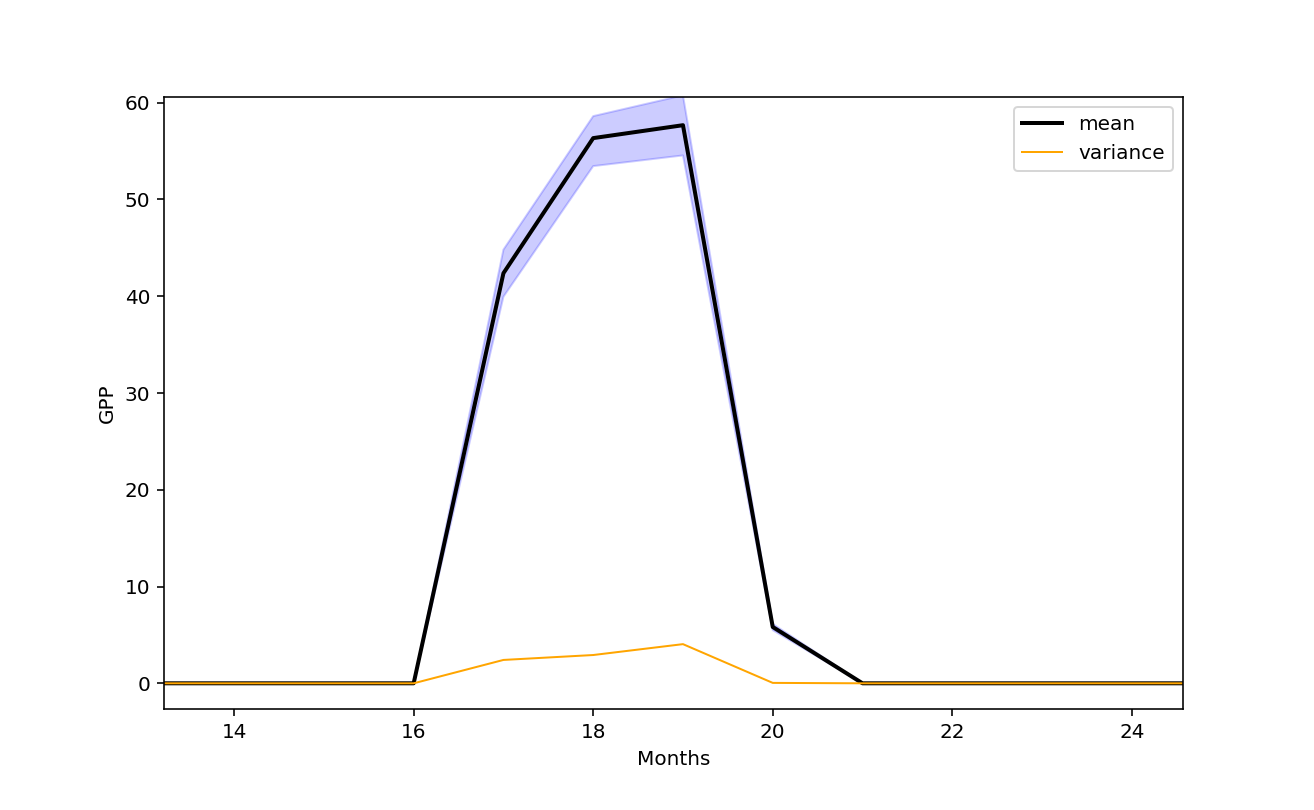

In [15]:
%matplotlib notebook
time = range(0,60)
#time = range(0,12)
plt.plot(time,mean,lw=2,color='black')
plt.fill_between(time, percentile_5, percentile_95, color='b', alpha=0.2)#
plt.plot(time,variance,lw=2,color='orange')
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.rcParams['figure.figsize'][0] = 40
plt.legend(['mean','variance'])